In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1";
import h5py
import numpy as np
import keras
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.utils import multi_gpu_model
import matplotlib.pyplot as plt
%matplotlib inline
import random
from scipy.special import expit
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model
import random

Using TensorFlow backend.


In [29]:
input_img=Input(shape= (40*40,))
layer=input_img
layer=Dense(1024,activation='relu')(layer)
layer=Dense(512,activation='relu')(layer)
layer=Dense(512,activation='relu')(layer)
layer=Dense(256,activation='relu')(layer)
layer=Dense(128,activation='relu')(layer)
layer=Dense(64,activation='relu')(layer)
layer=Dense(32,activation='relu')(layer)
layer=Dense(6, activation='relu')(layer)
layer=Dense(1, activation='sigmoid')(layer)

model=Model(input_img ,layer)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
model.summary()
#model.load_weights(".h5")
model.save_weights('densedeep.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1639424   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 64)                8256      
__________

In [ ]:
# Not all NN model can benefit from the keras parallel (https://github.com/keras-team/keras/issues/9204)

GPU = 2
if GPU > 1:
    # Multi-GPU 
    parallel_model = multi_gpu_model(model, gpus=2)
    parallel_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
    parallel_model.save_weights('parallel_densebase.h5')

In [3]:
f = h5py.File('/pub/daohangt/hep/data/all_118370.h5','r')
ee_x = f['features']['Ecal_E'][:]
et_x = f['features']['Ecal_ET'][:]
he_x = f['features']['Hcal_E'][:]
ht_x = f['features']['Hcal_ET'][:]
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)


In [4]:
ee_y = f['targets']['Ecal_E'][:]
et_y = f['targets']['Ecal_ET'][:]
he_y = f['targets']['Hcal_E'][:]
ht_y = f['targets']['Hcal_ET'][:]
print(ee_y.shape)
print(et_y.shape)
print(he_y.shape)
print(ht_y.shape)

(236740,)
(236740,)
(236740,)
(236740,)


In [37]:
# Separate bg/sig for visualizing the jet images
ee_i_bg, ee_i_sig = np.where(ee_y == 0)[0], np.where(ee_y == 1)[0]
ee_x_bg = ee_x[ee_i_bg]
ee_x_sig = ee_x[ee_i_sig]

et_i_bg, et_i_sig = np.where(et_y == 0)[0], np.where(et_y == 1)[0]
et_x_bg = et_x[et_i_bg]
et_x_sig = et_x[et_i_sig]

he_i_bg, he_i_sig = np.where(he_y == 0)[0], np.where(he_y == 1)[0]
he_x_bg = he_x[he_i_bg]
he_x_sig = he_x[he_i_sig]

ht_i_bg, ht_i_sig = np.where(ht_y == 0)[0], np.where(ht_y == 1)[0]
ht_x_bg = ht_x[ht_i_bg]
ht_x_sig = ht_x[ht_i_sig]

In [35]:
# Visualize the bg and sig jet images
def plot2(a,b,vmax,name,ta,tb):
    fig = plt.figure(figsize=(10, 10))
    row,col=1,2
    ax1 = fig.add_subplot(row,col,1)
    plt.imshow(a,cmap='Blues',vmin=-10,vmax=vmax)
    ax2 = fig.add_subplot(row,col,2)
    plt.imshow(b,cmap='Reds',vmin=-10,vmax=vmax)
    #plt.show()
    ax1.title.set_text(ta)
    ax2.title.set_text(tb)
    plt.savefig(name)
    
def plot2_nAgg(s,e,xbg,xsig,vmax,name,ta,tb):
    if len(xbg.shape) == 3:
        xbgg = np.copy(xbg[0])
        xsigg = np.copy(xsig[0])
        for i in range(s,e):
            xbgg += xbg[i]
            xsigg += xsig[i]
    else:
        xbgg = np.copy(xbg[0][0])
        xsigg = np.copy(xsig[0][0])
        for i in range(s,e):
            xbgg += xbg[i][0]
            xsigg += xsig[i][0]
    plot2(xbgg,xsigg,vmax,name,ta,tb)

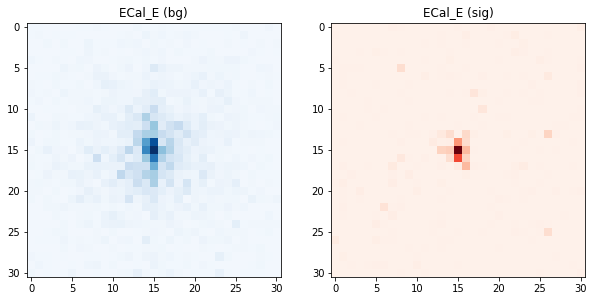

In [36]:
plot2_nAgg(0,1000,ee_x_bg,ee_x_sig,400,"ee.png",'ECal_E (bg)','ECal_E (sig)')

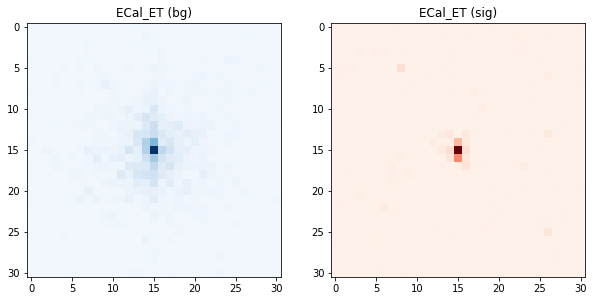

In [39]:
plot2_nAgg(0,1000,et_x_bg,et_x_sig,400,"et.png",'ECal_ET (bg)','ECal_ET (sig)')

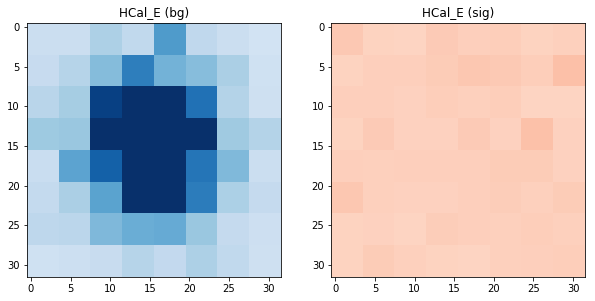

In [44]:
plot2_nAgg(0,1000,he_x_bg,he_x_sig,50,"he.png",'HCal_E (bg)','HCal_E (sig)')

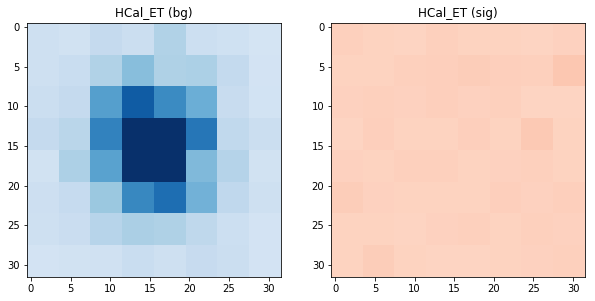

In [45]:
plot2_nAgg(0,1000,ht_x_bg,ht_x_sig,50,"ht.png",'HCal_ET (bg)','HCal_ET (sig)')

In [5]:
print("Before massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

def pad(x):
    if x.shape[-1] == 32:
        return np.pad(x,((0,0),(4,4),(4,4)), 'constant')
    else:
        # 31*31
        return np.pad(x,((0,0),(4,5),(4,5)), 'constant')

def extra(x):
    # Flatten individual images
    sz = (x.shape[0],x.shape[1]*x.shape[2])
    x = np.reshape(x, sz)
    return x

# Massage the data: padding + extra1
ee_x = extra(pad(ee_x))
et_x = extra(pad(et_x))
he_x = extra(pad(he_x))
ht_x = extra(pad(ht_x))

print("After massaging: ")
print(ee_x.shape)
print(et_x.shape)
print(he_x.shape)
print(ht_x.shape)

Before massaging: 
(236740, 31, 31)
(236740, 31, 31)
(236740, 32, 32)
(236740, 32, 32)
After massaging: 
(236740, 1600)
(236740, 1600)
(236740, 1600)
(236740, 1600)


In [6]:
# Splitting train & validation & test
# train & validation is used for telling overfitting
# test is used for evaluating the model (AUC)
def split(ee_x, ee_y, size, seed):
    ee_x_tr, ee_x_te, ee_y_tr, ee_y_te = train_test_split(ee_x, ee_y, test_size=size, random_state=seed)
    et_x_tr, et_x_te, et_y_tr, et_y_te = train_test_split(et_x, et_y, test_size=size, random_state=seed)
    he_x_tr, he_x_te, he_y_tr, he_y_te = train_test_split(he_x, he_y, test_size=size, random_state=seed)
    ht_x_tr, ht_x_te, ht_y_tr, ht_y_te = train_test_split(ht_x, ht_y, test_size=size, random_state=seed)

    ee_x_tr, ee_x_val, ee_y_tr, ee_y_val = train_test_split(ee_x_tr, ee_y_tr, test_size=size, random_state=seed)
    et_x_tr, et_x_val, et_y_tr, et_y_val = train_test_split(et_x_tr, et_y_tr, test_size=size, random_state=seed)
    he_x_tr, he_x_val, he_y_tr, he_y_val = train_test_split(he_x_tr, he_y_tr, test_size=size, random_state=seed)
    ht_x_tr, ht_x_val, ht_y_tr, ht_y_val = train_test_split(ht_x_tr, ht_y_tr, test_size=size, random_state=seed)  
    
    data = {"ee":[ee_x_tr, ee_x_val, ee_x_te, ee_y_tr, ee_y_val, ee_y_te],
            "et":[et_x_tr, et_x_val, et_x_te, et_y_tr, et_y_val, et_y_te],
            "he":[he_x_tr, he_x_val, he_x_te, he_y_tr, he_y_val, he_y_te],
            "ht":[ht_x_tr, ht_x_val, ht_x_te, ht_y_tr, ht_y_val, ht_y_te]}        
    
    return data

data = split(ee_x, ee_y, 0.2, 42)

In [30]:
# Final check for the shape
def printShape(data):
    lkup = {"ee":"ECal_E","et":"ECal_ET","he":"HCal_E","ht":"HCal_ET"}
    for k,v in data.items():
        print('\n'+lkup[k])
        for i in v:
            print(i.shape, end=";")

printShape(data)


ECal_E
(151513, 1600);(37879, 1600);(47348, 1600);(151513,);(37879,);(47348,);
ECal_ET
(151513, 1600);(37879, 1600);(47348, 1600);(151513,);(37879,);(47348,);
HCal_E
(151513, 1600);(37879, 1600);(47348, 1600);(151513,);(37879,);(47348,);
HCal_ET
(151513, 1600);(37879, 1600);(47348, 1600);(151513,);(37879,);(47348,);

In [38]:
def plot_al(history,aorl,t):
    plt.plot(history.history[aorl])
    plt.plot(history.history['val_'+aorl])
    plt.title(t + (" Accuracy" if aorl=="acc" else " Loss"))
    plt.ylabel(aorl)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def roc(true,pred,t):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(true, pred)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    print(roc_auc)
    plt.figure()
    plt.plot(fpr[1], tpr[1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['AUC={:.5}'.format(roc_auc[0])], loc='lower right')
    plt.title(t + ' ROC')
    plt.savefig(t+"_densedeeproc_"+str(roc_auc[0])+".png")
    plt.show()
    return roc_auc[0]
    
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                           patience=5, verbose=0,
                                           mode='auto', baseline=None,
                                           restore_best_weights=True)]

In [39]:
def run_model(model, data, idx, p=False):
    lkup = {"ee":"ECal_E","et":"ECal_ET","he":"HCal_E","ht":"HCal_ET"}
    model.load_weights(('parallel_' if p else '') + 'densedeep.h5')
    history = model.fit(data[idx][0], data[idx][3], epochs=20, batch_size=128, 
                    validation_data=(data[idx][1],data[idx][4]),verbose=1,
                    callbacks=callbacks)
    plot_al(history, 'loss', lkup[idx])
    y_hat = model.predict(data[idx][2])
    y_hat = np.reshape(y_hat,(y_hat.shape[0]))
    auc = roc(data[idx][5], y_hat, lkup[idx])
    model.save_weights(('parallel_' if p else '') +'densedeep_'+idx+'_20e_128b_'+str(auc)+'.h5')
    return auc

In [40]:
def run_model_Ntimes(N, model, ee_x, ee_y, idx, p=False):
    aucs = []
    for i in range(N):
        print("\n{}th iteration on {}:".format(i,idx))
        data = split(ee_x, ee_y, 0.2, random.randint(1,100))
        auc = run_model(model, data, idx, p=False)
        aucs.append(auc)
    return aucs

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 9s 57us/step - loss: 0.1306 - val_loss: 0.0752
Epoch 2/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0715 - val_loss: 0.0725
Epoch 3/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0659 - val_loss: 0.0745
Epoch 4/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0632 - val_loss: 0.0761
Epoch 5/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0621 - val_loss: 0.0771
Epoch 6/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0603 - val_loss: 0.0814
Epoch 7/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0587 - val_loss: 0.0879


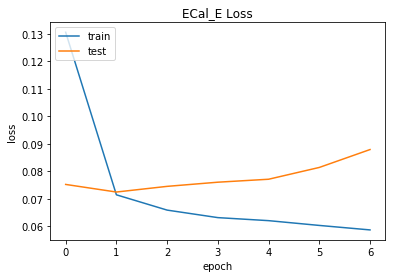

{0: 0.9966330606686084, 1: 0.9966330606686084}


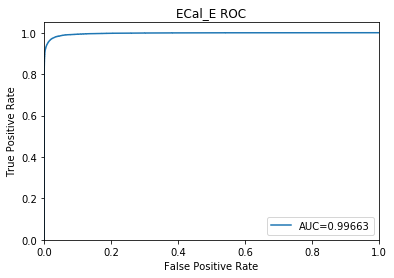

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.1127 - val_loss: 0.0750
Epoch 2/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0702 - val_loss: 0.0885
Epoch 3/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0669 - val_loss: 0.0888
Epoch 4/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0649 - val_loss: 0.0809
Epoch 5/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0625 - val_loss: 0.0782
Epoch 6/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0605 - val_loss: 0.0769


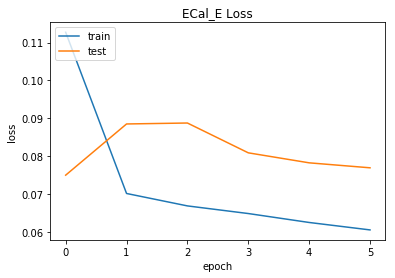

{0: 0.996136360714615, 1: 0.996136360714615}


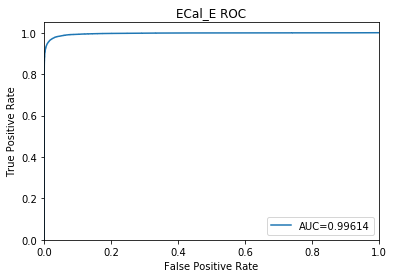

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.1479 - val_loss: 0.0799
Epoch 2/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0720 - val_loss: 0.0721
Epoch 3/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0659 - val_loss: 0.0801
Epoch 4/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0643 - val_loss: 0.0764
Epoch 5/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0628 - val_loss: 0.0780
Epoch 6/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0629 - val_loss: 0.0786
Epoch 7/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0595 - val_loss: 0.0901


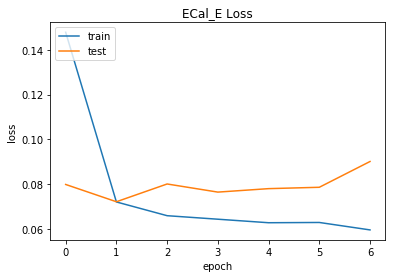

{0: 0.9963162596577212, 1: 0.9963162596577212}


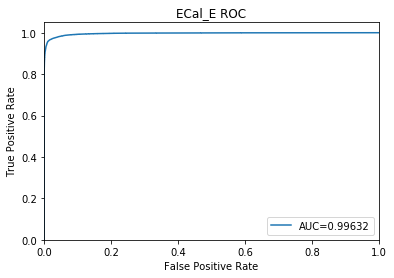

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.1191 - val_loss: 0.0718
Epoch 2/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0697 - val_loss: 0.0814
Epoch 3/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0657 - val_loss: 0.0772
Epoch 4/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0648 - val_loss: 0.0740
Epoch 5/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0625 - val_loss: 0.0875
Epoch 6/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0598 - val_loss: 0.0875


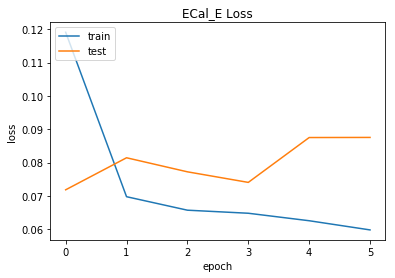

{0: 0.9961285736511547, 1: 0.9961285736511547}


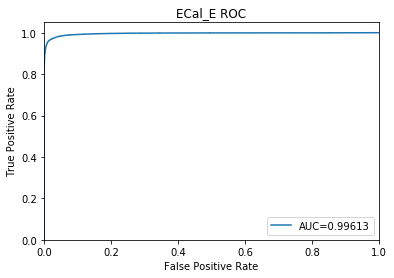

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.1142 - val_loss: 0.0707
Epoch 2/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0664 - val_loss: 0.0773
Epoch 3/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0640 - val_loss: 0.0748
Epoch 4/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0613 - val_loss: 0.0823
Epoch 5/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0605 - val_loss: 0.0780
Epoch 6/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0584 - val_loss: 0.0808


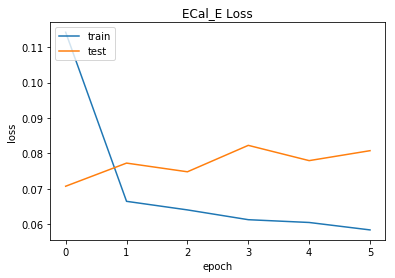

{0: 0.9964761115707979, 1: 0.9964761115707979}


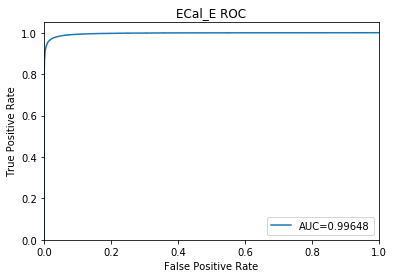

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.1461 - val_loss: 0.0804
Epoch 2/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0740 - val_loss: 0.0773
Epoch 3/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0671 - val_loss: 0.0817
Epoch 4/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0638 - val_loss: 0.0958
Epoch 5/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0615 - val_loss: 0.0776
Epoch 6/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0598 - val_loss: 0.0878
Epoch 7/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0594 - val_loss: 0.0838


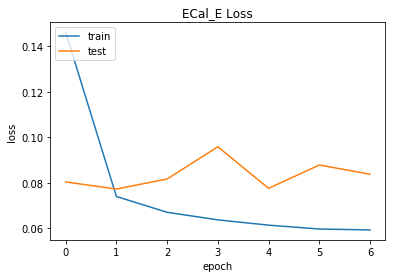

{0: 0.996027724313835, 1: 0.996027724313835}


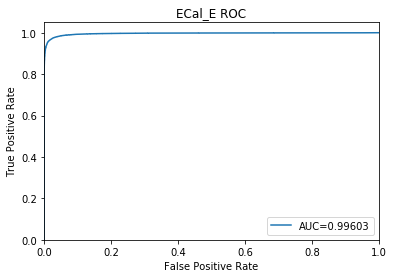

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.1102 - val_loss: 0.0694
Epoch 2/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0693 - val_loss: 0.0753
Epoch 3/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0646 - val_loss: 0.0836
Epoch 4/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0626 - val_loss: 0.0756
Epoch 5/20
151513/151513 [==============================] - 10s 67us/step - loss: 0.0611 - val_loss: 0.0826
Epoch 6/20
151513/151513 [==============================] - 10s 66us/step - loss: 0.0618 - val_loss: 0.0729


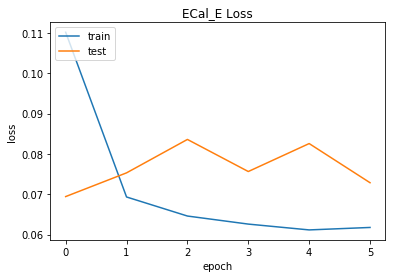

{0: 0.9964593237184849, 1: 0.9964593237184849}


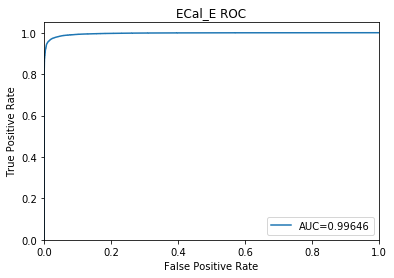

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.1289 - val_loss: 0.0728
Epoch 2/20
151513/151513 [==============================] - 8s 56us/step - loss: 0.0695 - val_loss: 0.0729
Epoch 3/20
151513/151513 [==============================] - 9s 56us/step - loss: 0.0647 - val_loss: 0.0790
Epoch 4/20
151513/151513 [==============================] - 8s 56us/step - loss: 0.0630 - val_loss: 0.0818
Epoch 5/20
151513/151513 [==============================] - 8s 56us/step - loss: 0.0615 - val_loss: 0.0788
Epoch 6/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.0612 - val_loss: 0.0797


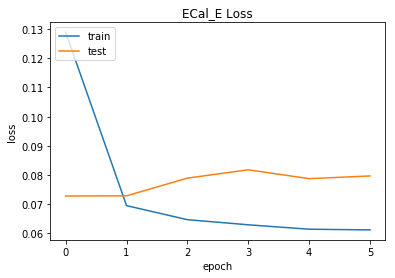

{0: 0.9963386596563524, 1: 0.9963386596563524}


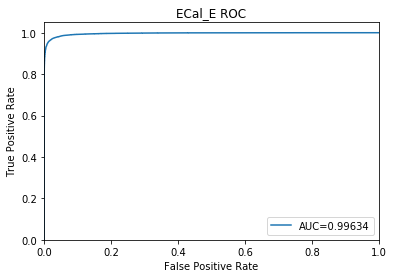

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 11s 74us/step - loss: 0.1161 - val_loss: 0.0774
Epoch 2/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0691 - val_loss: 0.0791
Epoch 3/20
151513/151513 [==============================] - 8s 55us/step - loss: 0.0650 - val_loss: 0.0791
Epoch 4/20
151513/151513 [==============================] - 11s 71us/step - loss: 0.0631 - val_loss: 0.0747
Epoch 5/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0622 - val_loss: 0.0808
Epoch 6/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0600 - val_loss: 0.1008
Epoch 7/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0590 - val_loss: 0.0833
Epoch 8/20
151513/151513 [==============================] - 8s 53us/step - loss: 0.0578 - val_loss: 0.0832
Epoch 9/20
151513/151513 [==============================] - 8s 53us/step - loss: 0.0580 - v

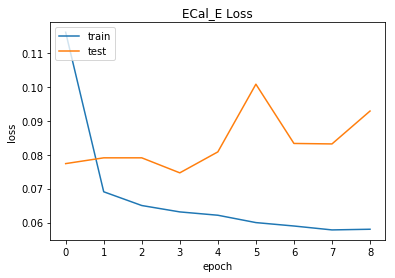

{0: 0.996280692267648, 1: 0.996280692267648}


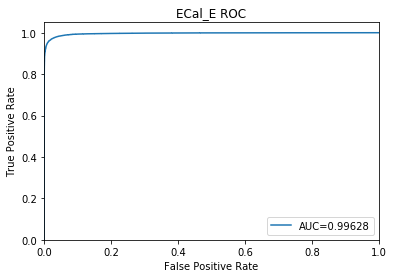

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.1380 - val_loss: 0.0775
Epoch 2/20
151513/151513 [==============================] - 8s 54us/step - loss: 0.0703 - val_loss: 0.0732
Epoch 3/20
151513/151513 [==============================] - 11s 71us/step - loss: 0.0664 - val_loss: 0.0771
Epoch 4/20
151513/151513 [==============================] - 9s 59us/step - loss: 0.0645 - val_loss: 0.0737
Epoch 5/20
151513/151513 [==============================] - 11s 75us/step - loss: 0.0636 - val_loss: 0.0841
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0631 - val_loss: 0.0848
Epoch 7/20
151513/151513 [==============================] - 11s 73us/step - loss: 0.0615 - val_loss: 0.0761


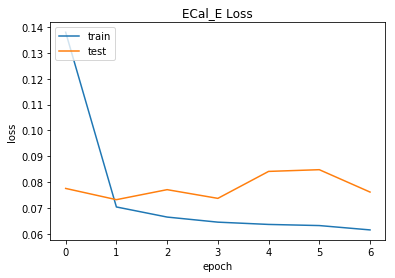

{0: 0.9960167544981329, 1: 0.9960167544981329}


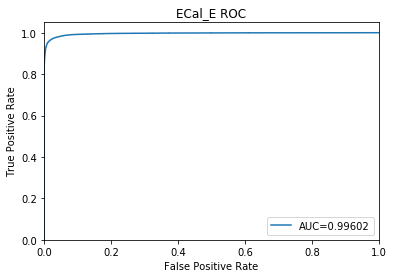

[0.9966330606686084, 0.996136360714615, 0.9963162596577212, 0.9961285736511547, 0.9964761115707979, 0.996027724313835, 0.9964593237184849, 0.9963386596563524, 0.996280692267648, 0.9960167544981329]


In [41]:
ee_aucs = run_model_Ntimes(10,model,ee_x,ee_y,"ee",p=False)
print(ee_aucs)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0854 - val_loss: 0.0482
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0395 - val_loss: 0.0485
Epoch 3/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.0365 - val_loss: 0.0476
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0354 - val_loss: 0.0500
Epoch 5/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0348 - val_loss: 0.0586
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0338 - val_loss: 0.0526
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0324 - val_loss: 0.0583
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0323 - val_loss: 0.0563


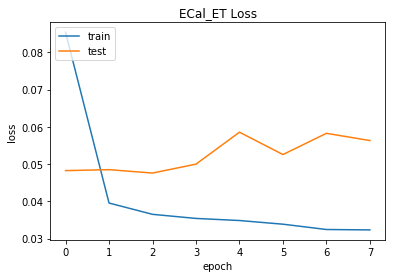

{0: 0.9984828527510345, 1: 0.9984828527510345}


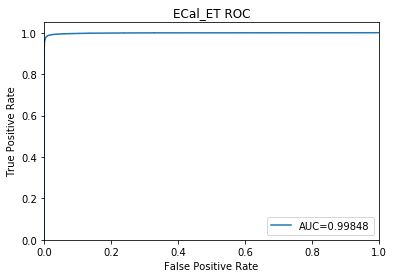

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0787 - val_loss: 0.0428
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0410 - val_loss: 0.0408
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0369 - val_loss: 0.0508
Epoch 4/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.0359 - val_loss: 0.0420
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0343 - val_loss: 0.0460
Epoch 6/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.0341 - val_loss: 0.0448
Epoch 7/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0329 - val_loss: 0.0534


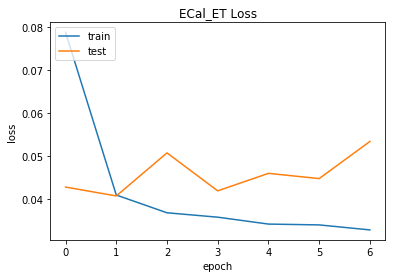

{0: 0.9982497495547353, 1: 0.9982497495547353}


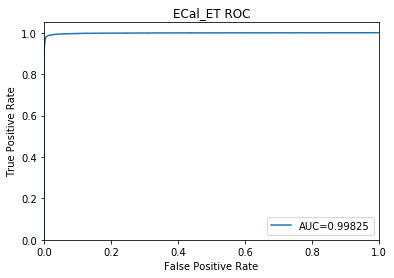

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0646 - val_loss: 0.0432
Epoch 2/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.0387 - val_loss: 0.0435
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0365 - val_loss: 0.0515
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0354 - val_loss: 0.0480
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0335 - val_loss: 0.0524
Epoch 6/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0333 - val_loss: 0.0450


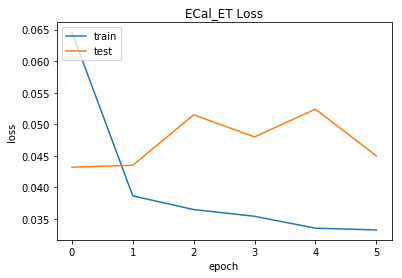

{0: 0.9983409576604165, 1: 0.9983409576604165}


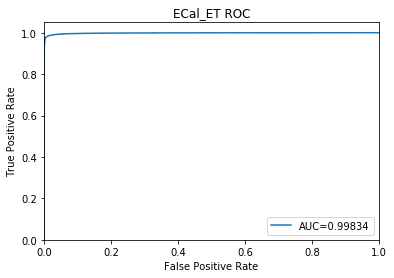

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0734 - val_loss: 0.0437
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0404 - val_loss: 0.0450
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0373 - val_loss: 0.0455
Epoch 4/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0360 - val_loss: 0.0494
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0350 - val_loss: 0.0478
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0344 - val_loss: 0.0579


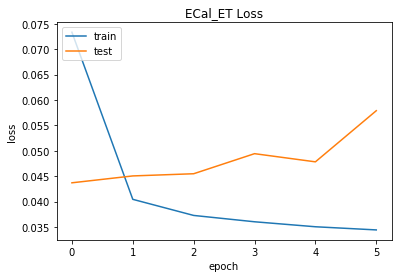

{0: 0.9985692129162607, 1: 0.9985692129162607}


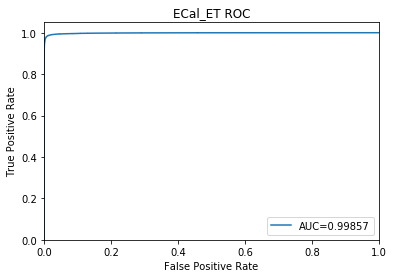

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0667 - val_loss: 0.0405
Epoch 2/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.0389 - val_loss: 0.0415
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0357 - val_loss: 0.0411
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0346 - val_loss: 0.0427
Epoch 5/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0332 - val_loss: 0.0498
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0328 - val_loss: 0.0475


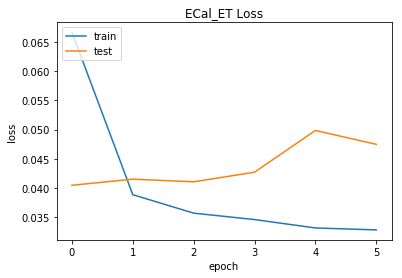

{0: 0.99849722904851, 1: 0.99849722904851}


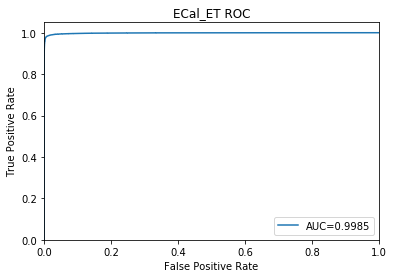

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0685 - val_loss: 0.0407
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0398 - val_loss: 0.0401
Epoch 3/20
151513/151513 [==============================] - 10s 68us/step - loss: 0.0375 - val_loss: 0.0437
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0365 - val_loss: 0.0476
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0350 - val_loss: 0.0506
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0337 - val_loss: 0.0493
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0338 - val_loss: 0.0470


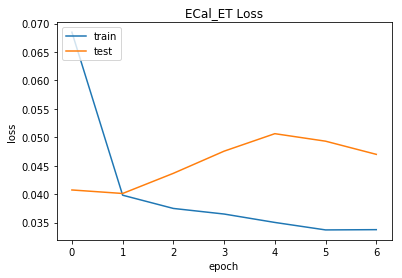

{0: 0.9985362326927905, 1: 0.9985362326927905}


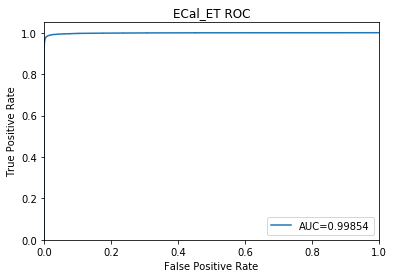

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.1004 - val_loss: 0.0463
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0404 - val_loss: 0.0490
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0365 - val_loss: 0.0487
Epoch 4/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0341 - val_loss: 0.0493
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0330 - val_loss: 0.0495
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0321 - val_loss: 0.0610


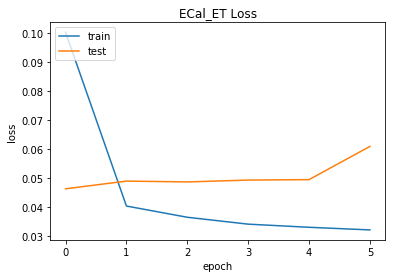

{0: 0.9978101796005487, 1: 0.9978101796005487}


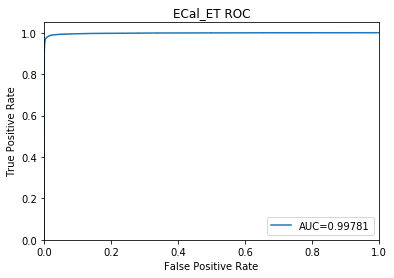

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0983 - val_loss: 0.0491
Epoch 2/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0408 - val_loss: 0.0435
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0369 - val_loss: 0.0462
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0350 - val_loss: 0.0501
Epoch 5/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0337 - val_loss: 0.0543
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0332 - val_loss: 0.0503
Epoch 7/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0327 - val_loss: 0.0543


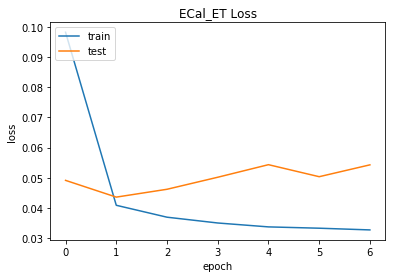

{0: 0.9983576351575659, 1: 0.9983576351575659}


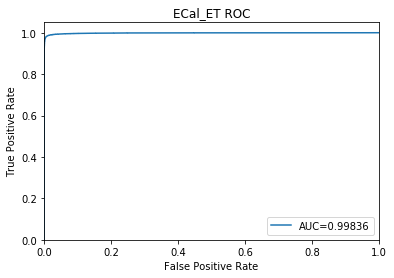

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0689 - val_loss: 0.0471
Epoch 2/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0394 - val_loss: 0.0460
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0365 - val_loss: 0.0541
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0352 - val_loss: 0.0481
Epoch 5/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0347 - val_loss: 0.0571
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0334 - val_loss: 0.0591
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0328 - val_loss: 0.0527


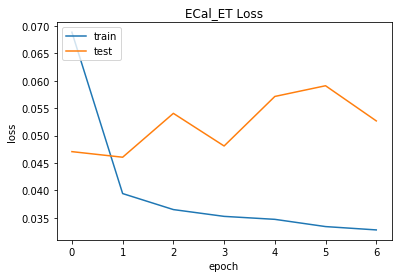

{0: 0.9985160432640481, 1: 0.9985160432640481}


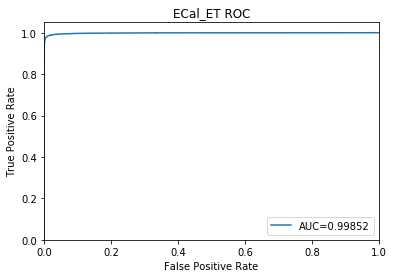

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0864 - val_loss: 0.0456
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.0402 - val_loss: 0.0454
Epoch 3/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0365 - val_loss: 0.0476
Epoch 4/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.0346 - val_loss: 0.0496
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.0339 - val_loss: 0.0557
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.0332 - val_loss: 0.0519
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.0318 - val_loss: 0.0512


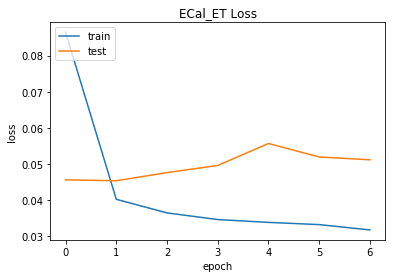

{0: 0.9981823259071727, 1: 0.9981823259071727}


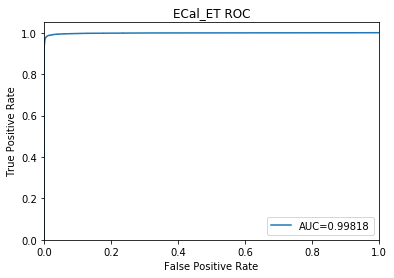

[0.9984828527510345, 0.9982497495547353, 0.9983409576604165, 0.9985692129162607, 0.99849722904851, 0.9985362326927905, 0.9978101796005487, 0.9983576351575659, 0.9985160432640481, 0.9981823259071727]


In [42]:
et_aucs = run_model_Ntimes(10,model,et_x,et_y,"et",p=False)
print(et_aucs)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3788 - val_loss: 0.3731
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3700 - val_loss: 0.3720
Epoch 3/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3675 - val_loss: 0.3720
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3657 - val_loss: 0.3690
Epoch 5/20
151513/151513 [==============================] - 14s 89us/step - loss: 0.3653 - val_loss: 0.3691
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3640 - val_loss: 0.3678
Epoch 7/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.3631 - val_loss: 0.3700
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3626 - val_loss: 0.3678
Epoch 9/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3

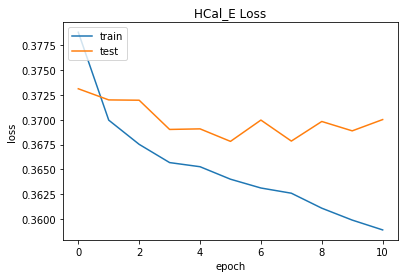

{0: 0.8871399518349243, 1: 0.8871399518349243}


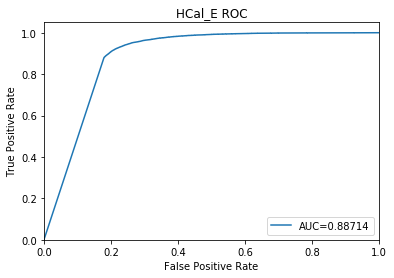

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3798 - val_loss: 0.3722
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3711 - val_loss: 0.3710
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3688 - val_loss: 0.3689
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3668 - val_loss: 0.3717
Epoch 5/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3659 - val_loss: 0.3713
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3648 - val_loss: 0.3677
Epoch 7/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3647 - val_loss: 0.3683
Epoch 8/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3633 - val_loss: 0.3683
Epoch 9/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3

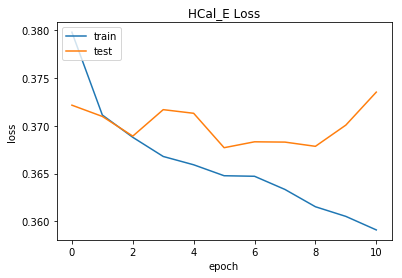

{0: 0.8868470441784958, 1: 0.8868470441784958}


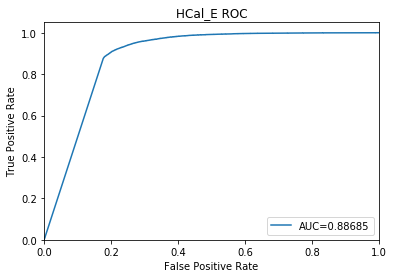

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3799 - val_loss: 0.3747
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3706 - val_loss: 0.3715
Epoch 3/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.3676 - val_loss: 0.3703
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3661 - val_loss: 0.3710
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3651 - val_loss: 0.3704
Epoch 6/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3635 - val_loss: 0.3702
Epoch 7/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3625 - val_loss: 0.3697
Epoch 8/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3612 - val_loss: 0.3736
Epoch 9/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3

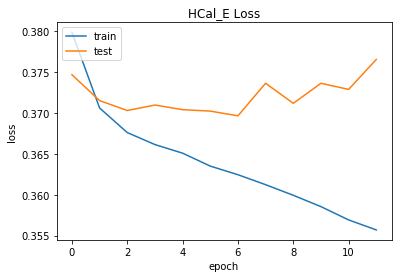

{0: 0.8881417515322655, 1: 0.8881417515322655}


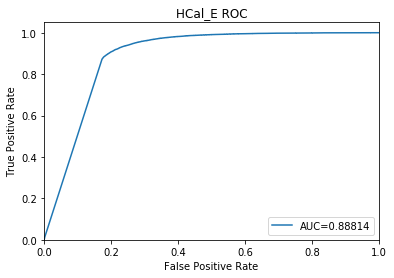

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3823 - val_loss: 0.3771
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3730 - val_loss: 0.3750
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3704 - val_loss: 0.3699
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3687 - val_loss: 0.3700
Epoch 5/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.3667 - val_loss: 0.3678
Epoch 6/20
151513/151513 [==============================] - 14s 91us/step - loss: 0.3656 - val_loss: 0.3685
Epoch 7/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3646 - val_loss: 0.3680
Epoch 8/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3635 - val_loss: 0.3680
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

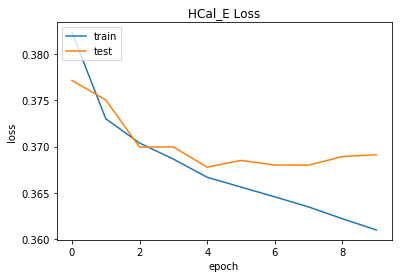

{0: 0.8897726272304841, 1: 0.8897726272304841}


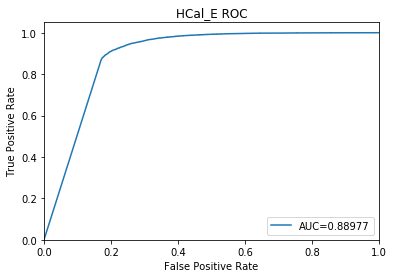

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3811 - val_loss: 0.3739
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3739 - val_loss: 0.3727
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3711 - val_loss: 0.3701
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3690 - val_loss: 0.3673
Epoch 5/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3671 - val_loss: 0.3667
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3657 - val_loss: 0.3678
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3648 - val_loss: 0.3690
Epoch 8/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3629 - val_loss: 0.3680
Epoch 9/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3

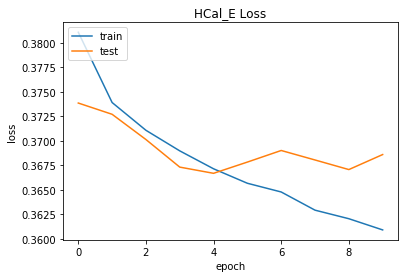

{0: 0.887021973567831, 1: 0.887021973567831}


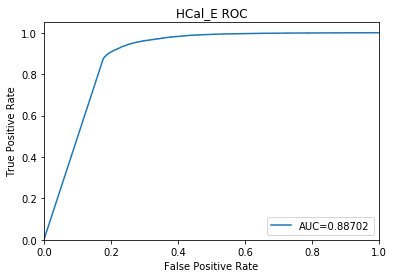

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3822 - val_loss: 0.3780
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3738 - val_loss: 0.3736
Epoch 3/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3715 - val_loss: 0.3697
Epoch 4/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3691 - val_loss: 0.3681
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3676 - val_loss: 0.3691
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3665 - val_loss: 0.3676
Epoch 7/20
151513/151513 [==============================] - 13s 87us/step - loss: 0.3655 - val_loss: 0.3674
Epoch 8/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3648 - val_loss: 0.3705
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

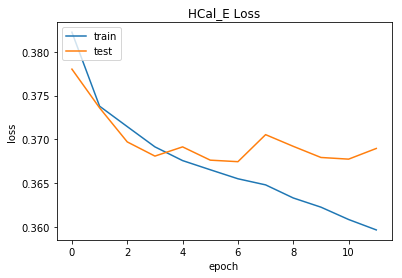

{0: 0.8897313054107094, 1: 0.8897313054107094}


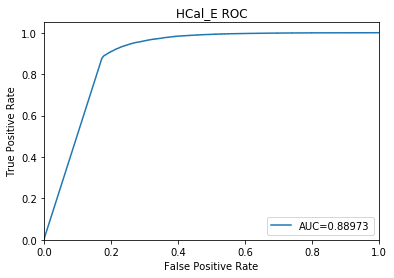

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3780 - val_loss: 0.3743
Epoch 2/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3708 - val_loss: 0.3710
Epoch 3/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3679 - val_loss: 0.3696
Epoch 4/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3663 - val_loss: 0.3681
Epoch 5/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3650 - val_loss: 0.3683
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3645 - val_loss: 0.3691
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3633 - val_loss: 0.3693
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3626 - val_loss: 0.3690
Epoch 9/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3

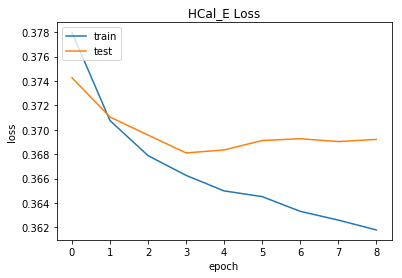

{0: 0.8866711644645915, 1: 0.8866711644645915}


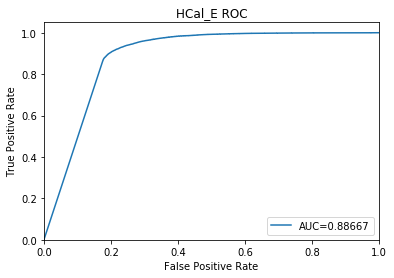

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3803 - val_loss: 0.3767
Epoch 2/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3726 - val_loss: 0.3749
Epoch 3/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3698 - val_loss: 0.3708
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3681 - val_loss: 0.3710
Epoch 5/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3672 - val_loss: 0.3695
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3657 - val_loss: 0.3683
Epoch 7/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.3653 - val_loss: 0.3691
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3638 - val_loss: 0.3713
Epoch 9/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3

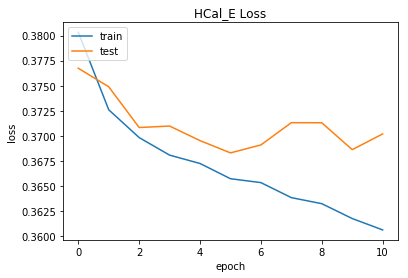

{0: 0.8894631435542764, 1: 0.8894631435542764}


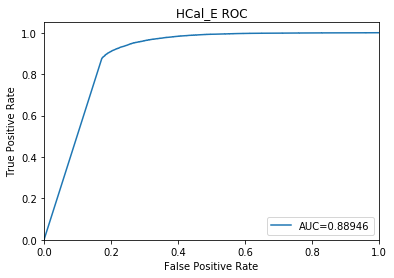

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3801 - val_loss: 0.3782
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3741 - val_loss: 0.3735
Epoch 3/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3691 - val_loss: 0.3709
Epoch 4/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3674 - val_loss: 0.3703
Epoch 5/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3663 - val_loss: 0.3701
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3652 - val_loss: 0.3683
Epoch 7/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3643 - val_loss: 0.3677
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3633 - val_loss: 0.3697
Epoch 9/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3

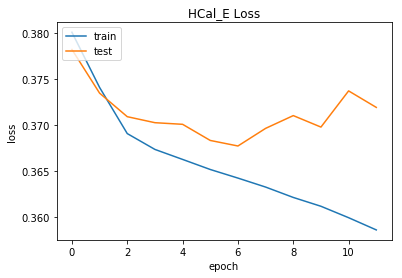

{0: 0.8876583086602781, 1: 0.8876583086602781}


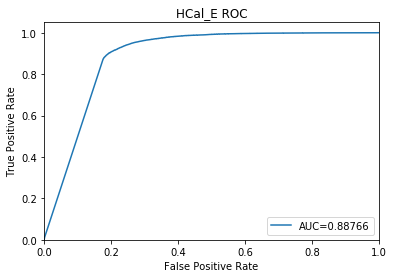

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3804 - val_loss: 0.3756
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3717 - val_loss: 0.3728
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3695 - val_loss: 0.3710
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3682 - val_loss: 0.3728
Epoch 5/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3663 - val_loss: 0.3708
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3657 - val_loss: 0.3756
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3647 - val_loss: 0.3699
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3639 - val_loss: 0.3716
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

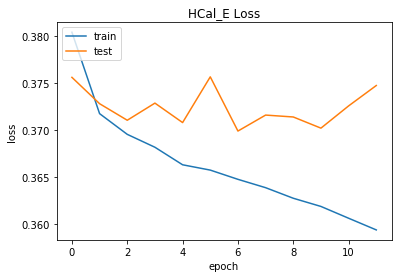

{0: 0.8899487824262021, 1: 0.8899487824262021}


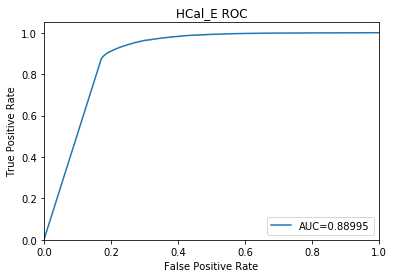

[0.8871399518349243, 0.8868470441784958, 0.8881417515322655, 0.8897726272304841, 0.887021973567831, 0.8897313054107094, 0.8866711644645915, 0.8894631435542764, 0.8876583086602781, 0.8899487824262021]


In [43]:
he_aucs = run_model_Ntimes(10,model,he_x,he_y,"he",p=False)
print(he_aucs)

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3670 - val_loss: 0.3550
Epoch 2/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3578 - val_loss: 0.3529
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3550 - val_loss: 0.3511
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3537 - val_loss: 0.3504
Epoch 5/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3526 - val_loss: 0.3492
Epoch 6/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3516 - val_loss: 0.3518
Epoch 7/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3510 - val_loss: 0.3505
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3500 - val_loss: 0.3489
Epoch 9/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3

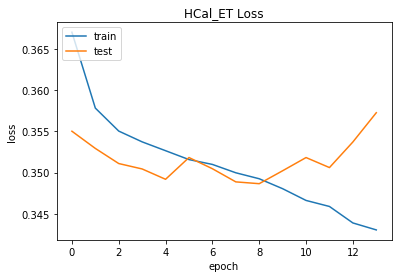

{0: 0.8898961987672087, 1: 0.8898961987672087}


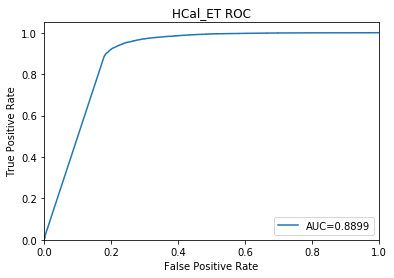

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3674 - val_loss: 0.3554
Epoch 2/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3573 - val_loss: 0.3533
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3554 - val_loss: 0.3516
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3547 - val_loss: 0.3510
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3540 - val_loss: 0.3503
Epoch 6/20
151513/151513 [==============================] - 13s 86us/step - loss: 0.3531 - val_loss: 0.3501
Epoch 7/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3527 - val_loss: 0.3502
Epoch 8/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.3519 - val_loss: 0.3512
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

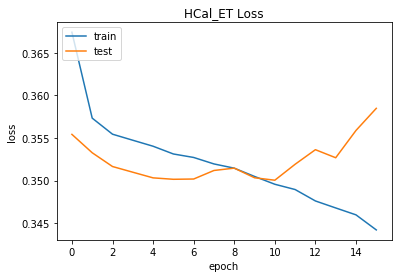

{0: 0.8913220759163709, 1: 0.8913220759163709}


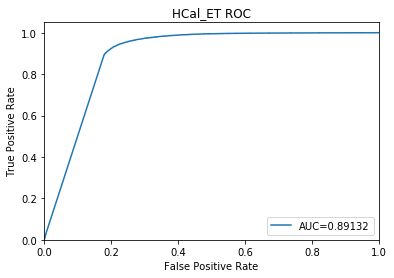

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3678 - val_loss: 0.3595
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3587 - val_loss: 0.3546
Epoch 3/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3558 - val_loss: 0.3539
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3540 - val_loss: 0.3547
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3531 - val_loss: 0.3529
Epoch 6/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3523 - val_loss: 0.3553
Epoch 7/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3518 - val_loss: 0.3551
Epoch 8/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3511 - val_loss: 0.3529
Epoch 9/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3

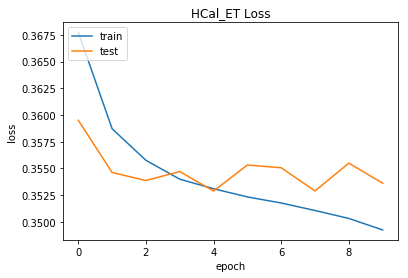

{0: 0.8926046202951624, 1: 0.8926046202951624}


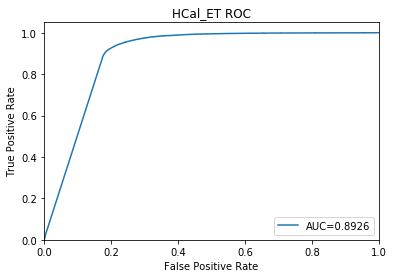

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3693 - val_loss: 0.3569
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3586 - val_loss: 0.3574
Epoch 3/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3556 - val_loss: 0.3533
Epoch 4/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3541 - val_loss: 0.3554
Epoch 5/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3530 - val_loss: 0.3527
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3520 - val_loss: 0.3542
Epoch 7/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3511 - val_loss: 0.3536
Epoch 8/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3500 - val_loss: 0.3529
Epoch 9/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3

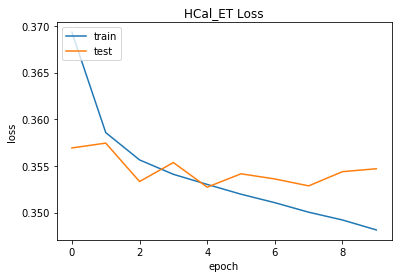

{0: 0.8910005502551748, 1: 0.8910005502551748}


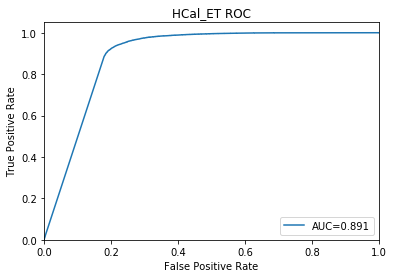

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3680 - val_loss: 0.3629
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3590 - val_loss: 0.3584
Epoch 3/20
151513/151513 [==============================] - 13s 84us/step - loss: 0.3560 - val_loss: 0.3579
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3545 - val_loss: 0.3538
Epoch 5/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3528 - val_loss: 0.3538
Epoch 6/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3519 - val_loss: 0.3558
Epoch 7/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3507 - val_loss: 0.3540
Epoch 8/20
151513/151513 [==============================] - 13s 84us/step - loss: 0.3499 - val_loss: 0.3536
Epoch 9/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3

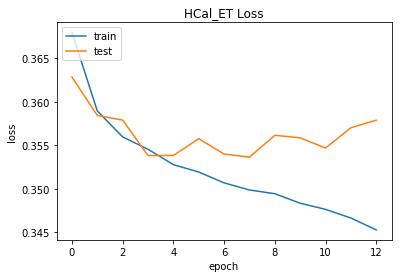

{0: 0.8912023105192237, 1: 0.8912023105192237}


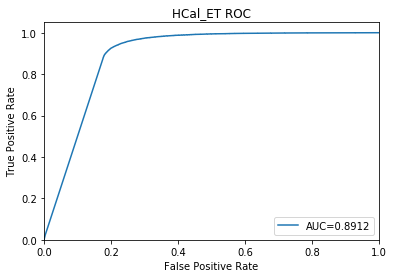

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3681 - val_loss: 0.3650
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3588 - val_loss: 0.3611
Epoch 3/20
151513/151513 [==============================] - 14s 90us/step - loss: 0.3558 - val_loss: 0.3573
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3542 - val_loss: 0.3558
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3535 - val_loss: 0.3552
Epoch 6/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3527 - val_loss: 0.3579
Epoch 7/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3517 - val_loss: 0.3586
Epoch 8/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3510 - val_loss: 0.3551
Epoch 9/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3

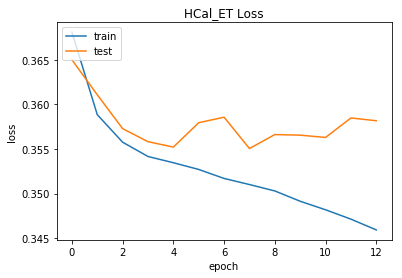

{0: 0.8926962219222058, 1: 0.8926962219222058}


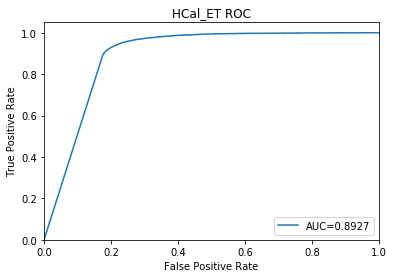

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3819 - val_loss: 0.3605
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3576 - val_loss: 0.3590
Epoch 3/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3552 - val_loss: 0.3553
Epoch 4/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3539 - val_loss: 0.3533
Epoch 5/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3529 - val_loss: 0.3545
Epoch 6/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3522 - val_loss: 0.3552
Epoch 7/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3516 - val_loss: 0.3528
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3509 - val_loss: 0.3528
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

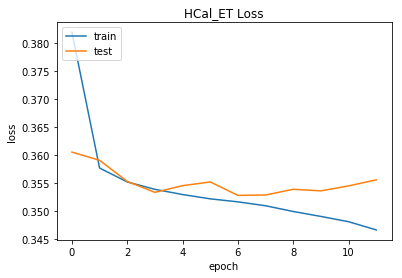

{0: 0.8921840344179357, 1: 0.8921840344179357}


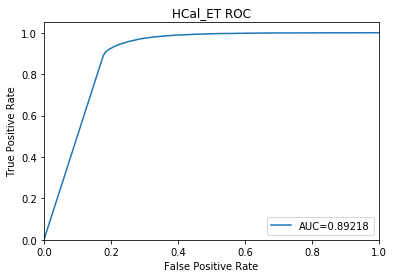

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3662 - val_loss: 0.3590
Epoch 2/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3575 - val_loss: 0.3571
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3553 - val_loss: 0.3553
Epoch 4/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3536 - val_loss: 0.3553
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3529 - val_loss: 0.3556
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3516 - val_loss: 0.3555
Epoch 7/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3514 - val_loss: 0.3565
Epoch 8/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3506 - val_loss: 0.3562
Epoch 9/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3

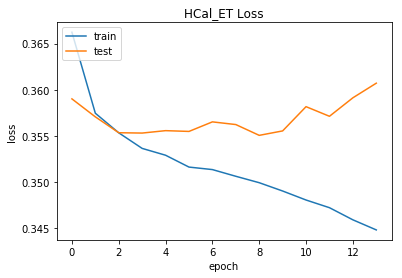

{0: 0.8933379019570754, 1: 0.8933379019570754}


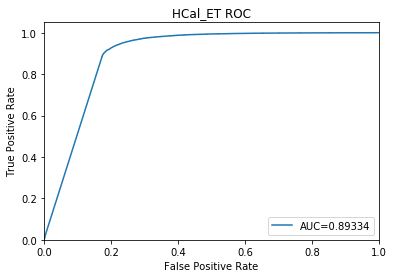

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3679 - val_loss: 0.3610
Epoch 2/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3582 - val_loss: 0.3556
Epoch 3/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3557 - val_loss: 0.3534
Epoch 4/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3544 - val_loss: 0.3533
Epoch 5/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3531 - val_loss: 0.3533
Epoch 6/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3525 - val_loss: 0.3536
Epoch 7/20
151513/151513 [==============================] - 13s 88us/step - loss: 0.3515 - val_loss: 0.3547
Epoch 8/20
151513/151513 [==============================] - 12s 82us/step - loss: 0.3508 - val_loss: 0.3530
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

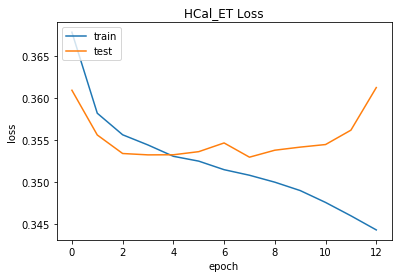

{0: 0.8926460495186098, 1: 0.8926460495186098}


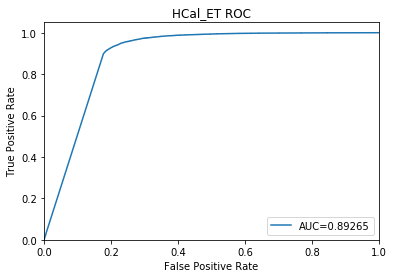

Train on 151513 samples, validate on 37879 samples
Epoch 1/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3686 - val_loss: 0.3636
Epoch 2/20
151513/151513 [==============================] - 13s 84us/step - loss: 0.3589 - val_loss: 0.3563
Epoch 3/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3559 - val_loss: 0.3581
Epoch 4/20
151513/151513 [==============================] - 13s 83us/step - loss: 0.3544 - val_loss: 0.3538
Epoch 5/20
151513/151513 [==============================] - 12s 78us/step - loss: 0.3534 - val_loss: 0.3533
Epoch 6/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3523 - val_loss: 0.3536
Epoch 7/20
151513/151513 [==============================] - 12s 80us/step - loss: 0.3513 - val_loss: 0.3563
Epoch 8/20
151513/151513 [==============================] - 12s 79us/step - loss: 0.3509 - val_loss: 0.3539
Epoch 9/20
151513/151513 [==============================] - 12s 81us/step - loss: 0.3

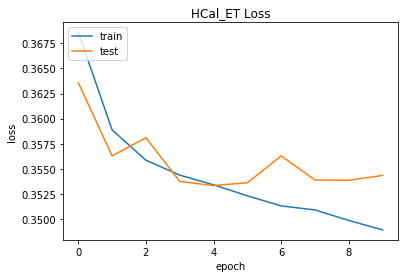

{0: 0.8937013129568236, 1: 0.8937013129568236}


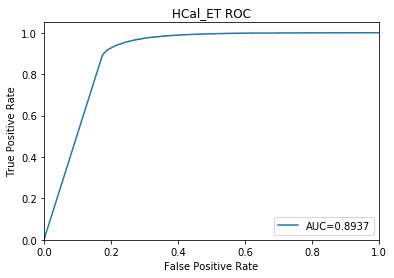

[0.8898961987672087, 0.8913220759163709, 0.8926046202951624, 0.8910005502551748, 0.8912023105192237, 0.8926962219222058, 0.8921840344179357, 0.8933379019570754, 0.8926460495186098, 0.8937013129568236]


In [44]:
ht_aucs = run_model_Ntimes(10,model,ht_x,ht_y,"ht",p=False)
print(ht_aucs)

In [45]:
print("Done")

Done
